# Veille Technologique - Modele CNN ResNet50 vs Vision Transformers (ViT)

## Imports et config

In [1]:
# %pip install timm

In [63]:
import os
import cv2
import timm
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from torch import nn, optim
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Device: cpu


## Chargement du dataset

In [3]:
SOURCES_PATH = "../Sources/"
CSV_FILE = "flipkart_com-ecommerce_sample_1050.csv"
CSV_FILEPATH = SOURCES_PATH + CSV_FILE
IMG_ROOT = Path(SOURCES_PATH + "Images/")

df = pd.read_csv(CSV_FILEPATH)

print('DataSet Shape = {}'.format(df.shape))
print('DataSet Memory Usage = {:.2f} MB'.format(df.memory_usage().sum() / 1024**2))

DataSet Shape = (1050, 15)
DataSet Memory Usage = 0.11 MB


#### Je cree ma colonne avec mes 7 categories

In [4]:
df['category_simple'] = df['product_category_tree'].apply(lambda x: x.split(' >> ')[0].split('["')[1])

#### On conserve uniquement les lignes avec des images existantes, mesure de securite

In [5]:
def img_exists(row):
    return (IMG_ROOT / str(row["image"])).exists()

In [6]:
df['img_path'] = df['image'].apply(lambda x: IMG_ROOT / str(x))
print("Nombre total de lignes/images:", len(df))

Nombre total de lignes/images: 1050


#### Encodage des labels

In [7]:
classes = sorted(df['category_simple'].unique())
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

In [8]:
df['label'] = df['category_simple'].map(class_to_idx)
num_classes = len(classes)
print("Classes:", classes)

Classes: ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


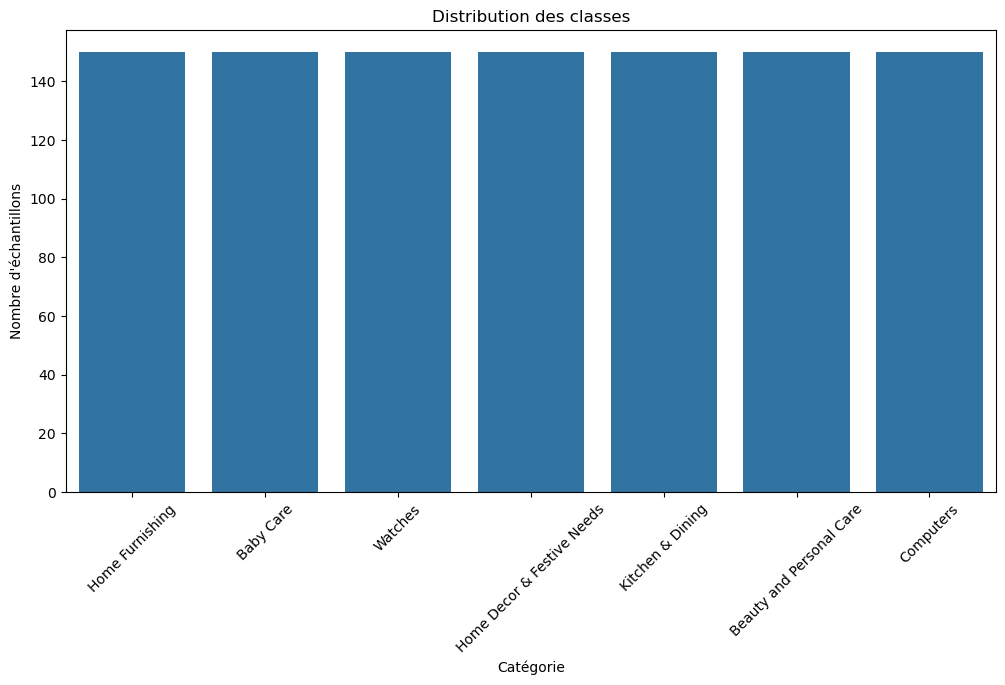

In [9]:
# barplot des classes
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='category_simple', order=df['category_simple'].value_counts().index)
plt.title('Distribution des classes')
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'échantillons')
plt.xticks(rotation=45)
plt.show()

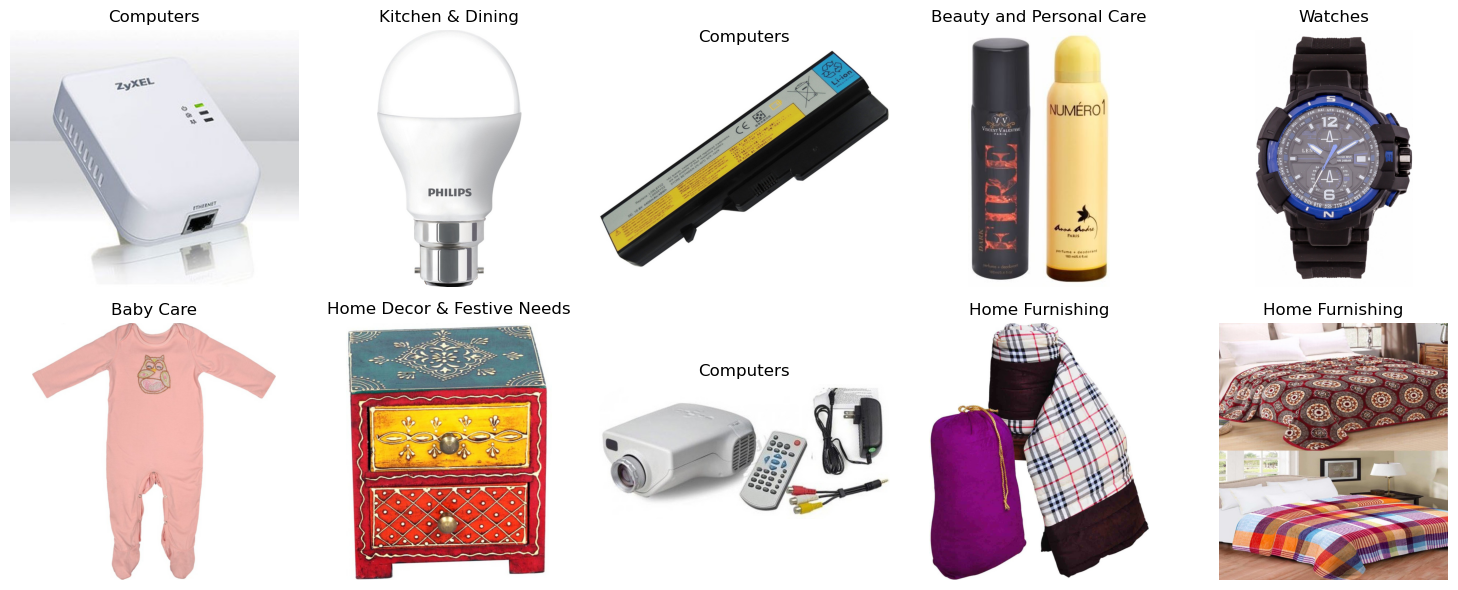

In [10]:
# Visualisation de quelques images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
sampled_df = df.sample(10, random_state=SEED).reset_index(drop=True)
for i, ax in enumerate(axes.flatten()):
    img_path = sampled_df.loc[i, 'img_path']
    label = sampled_df.loc[i, 'category_simple']
    image = Image.open(img_path).convert('RGB')
    ax.imshow(image)
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Split train / val / test

#### Stratifier sur la categorie

In [11]:
train_df, test_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=SEED
)

In [12]:
train_df['label'].value_counts()

label
3    105
5    105
1    105
2    105
6    105
4    105
0    105
Name: count, dtype: int64

In [13]:
test_df['label'].value_counts()

label
4    45
5    45
1    45
6    45
0    45
3    45
2    45
Name: count, dtype: int64

### Le jeu de 1050 images est découpé en deux sous ensembles disjoints :
#### Entraînement : train = 70%
#### Test : test = 30%


In [14]:
len(train_df), len(test_df)

(735, 315)

## Dataset PyTorch + data augmentation

In [15]:
IMG_SIZE = 224

In [16]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

#### Class pour les images

In [17]:
class FlipkartImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['img_path']).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = int(row['label'])
        return img, label

In [18]:
train_dataset = FlipkartImageDataset(train_df, transform=train_transform)
test_dataset   = FlipkartImageDataset(test_df, transform=eval_transform)

# Train "clean" = mêmes images que le train, mais sans data augmentation
train_dataset_clean = FlipkartImageDataset(train_df, transform=eval_transform)

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader   = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

train_loader_clean  = DataLoader(train_dataset_clean, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

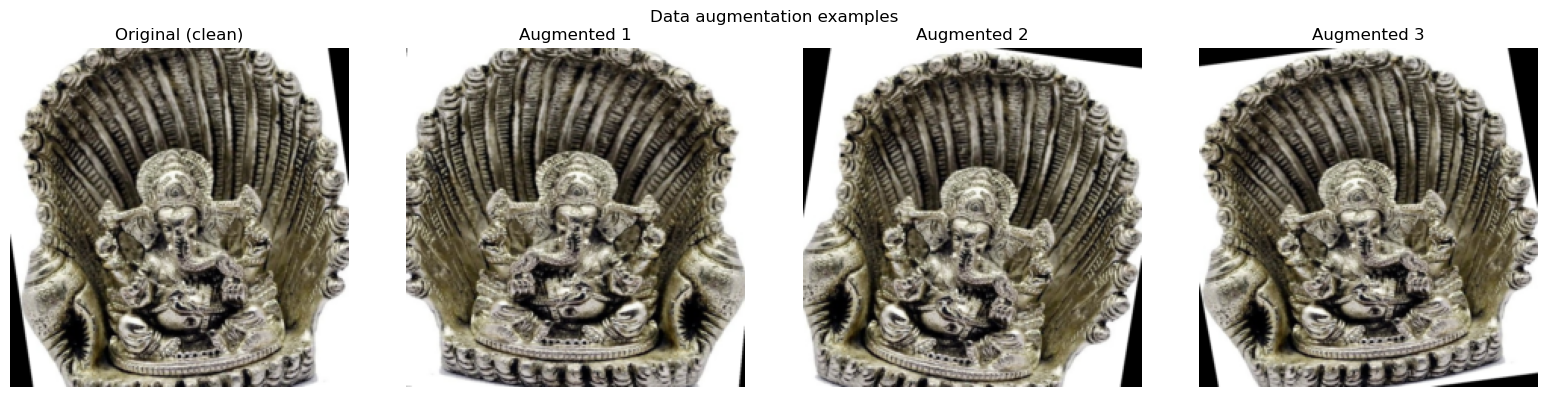

In [19]:
# affiche 1 image originale et 3 versions transformées crop/rotation/flip grace au train_transform
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def denormalize(tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    x = tensor.clone().detach().cpu()
    for c, (m, s) in enumerate(zip(mean, std)):
        x[c] = x[c] * s + m
    x = torch.clamp(x, 0, 1)
    return x.permute(1, 2, 0).numpy()


def show_augmentations_from_dataset(dataset, idx=0, n_aug=3, title="Data augmentation examples"):
   
    img_path = dataset.df.iloc[idx]['img_path']

    img = Image.open(img_path).convert("RGB")

    orig_tensor = train_transform(img)
    orig_np = denormalize(orig_tensor)

    aug_nps = []
    for _ in range(n_aug):
        aug_tensor = train_dataset.transform(img)
        aug_nps.append(denormalize(aug_tensor))

    cols = 1 + n_aug
    plt.figure(figsize=(4 * cols, 4))
    plt.subplot(1, cols, 1)
    plt.imshow(orig_np)
    plt.title("Original (clean)")
    plt.axis("off")

    for i in range(n_aug):
        plt.subplot(1, cols, i + 2)
        plt.imshow(aug_nps[i])
        plt.title(f"Augmented {i+1}")
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_augmentations_from_dataset(train_dataset, idx=0, n_aug=3, title="Data augmentation examples")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


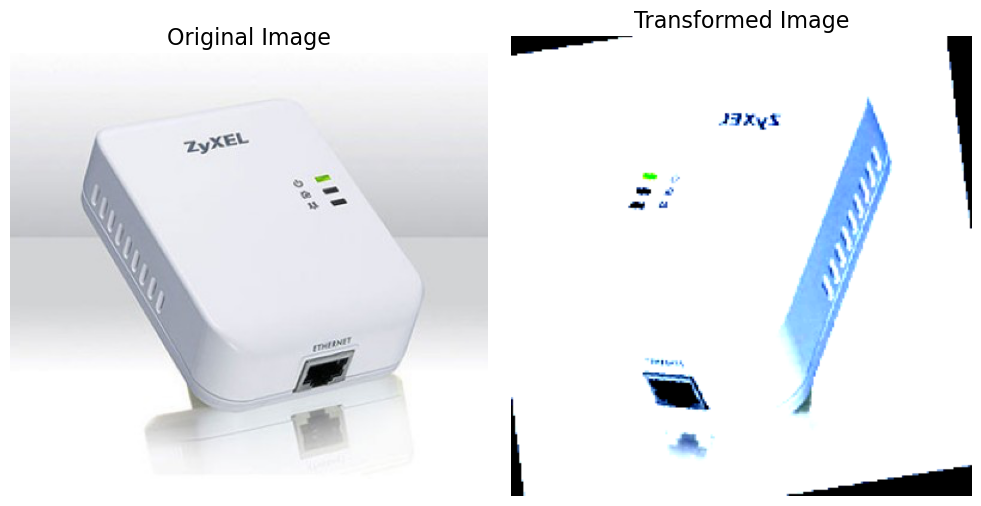

In [20]:
def show_original_and_transformed_image(df, train_transform, SEED):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sample_img_path = df.sample(1, random_state=SEED).iloc[0]['img_path']
    original_img = Image.open(sample_img_path).convert("RGB")
    orig_tensor = train_transform(original_img)
    axes[0].imshow(original_img)
    axes[0].axis('off')
    axes[0].set_title('Original Image', fontsize=16)
    axes[1].imshow(orig_tensor.permute(1, 2, 0).numpy())
    axes[1].axis('off')
    axes[1].set_title('Transformed Image', fontsize=16)
    plt.tight_layout()
    plt.show()
show_original_and_transformed_image(df, train_transform, SEED)

## Fonctions utilitaires pour l'entrainement et l'evaluation

In [21]:
def mixup_data(x, y, alpha=0.4):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = torch.distributions.Beta(alpha, alpha).sample().item()
    idx = torch.randperm(x.size(0), device=x.device)
    mixed_x = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, y_a, y_b, lam

def mixup_loss(criterion, logits, y_a, y_b, lam):
    return lam * criterion(logits, y_a) + (1 - lam) * criterion(logits, y_b)

In [22]:
def train_one_epoch(model, loader, criterion, optimizer, log_every=20, mixup_alpha=0.4):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)

        if mixup_alpha and mixup_alpha > 0:
            images, y_a, y_b, lam = mixup_data(images, labels, alpha=mixup_alpha)

        optimizer.zero_grad()
        outputs = model(images)

        if mixup_alpha and mixup_alpha > 0:
            loss = mixup_loss(criterion, outputs, y_a, y_b, lam)
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        if i % log_every == 0:
            print(f"batch {i}/{len(loader)} | loss={loss.item():.3f} | acc={(correct/total):.3f}")

    return running_loss / len(loader.dataset), correct / total

In [23]:
@torch.inference_mode()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc, np.array(all_labels), np.array(all_preds)

#### Visualisations

In [24]:
def plot_history(history, title=""):
    epochs = range(1, len(history["train_loss"]) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Loss
    axes[0].plot(epochs, history["train_loss"], label="Train (Augmented)")
    axes[0].plot(epochs, history["val_loss"],   label="Val")
    if "train_clean_loss" in history and len(history["train_clean_loss"]) == len(history["train_loss"]):
        axes[0].plot(epochs, history["train_clean_loss"], label="Train (Non augmented)")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()

    # Accuracy
    axes[1].plot(epochs, history["train_acc"], label="Train (Augmented)")
    axes[1].plot(epochs, history["val_acc"],   label="Val")
    if "train_clean_acc" in history and len(history["train_clean_acc"]) == len(history["train_acc"]):
        axes[1].plot(epochs, history["train_clean_acc"], label="Train (Non augmented)")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

## Modele CNN Baseline : ResNet50

In [25]:
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

#### On remplace la derniere couche FC par notre tete et on gele le backbone

In [26]:
for param in resnet.parameters():
    param.requires_grad = False

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)

resnet = resnet.to(device)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4, weight_decay=1e-4)

In [28]:
EPOCHS = 15
best_val_acc = 0.0
history_resnet = {"train_loss": [], "train_clean_loss": [], "val_loss": [], "train_acc": [], "train_clean_acc": [], "val_acc": []}

In [29]:
patience = 5  # Nombre d'époques à attendre avant d'arrêter si aucune amélioration
patience_counter = 0 # Compteur pour le nombre d'époques sans amélioration

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(resnet, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(resnet, test_loader, criterion)

    # accuracy sur train sans augmentation
    train_clean_loss, train_clean_acc, _, _ = evaluate(resnet, train_loader_clean, criterion)

    history_resnet["train_loss"].append(train_loss)
    history_resnet["train_clean_loss"].append(train_clean_loss)
    history_resnet["val_loss"].append(val_loss)
    history_resnet["train_acc"].append(train_acc)
    history_resnet["train_clean_acc"].append(train_clean_acc)
    history_resnet["val_acc"].append(val_acc)

    print(f"[ResNet] Epoch {epoch:02d} | "
          f"Train loss={train_loss:.3f}, acc={train_acc:.3f} | "
          f"Val loss={val_loss:.3f}, acc={val_acc:.3f} | "
          f"Train(Non augmented) loss={train_clean_loss:.3f}, acc={train_clean_acc:.3f}")

    # Logique d'early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet.state_dict(), "resnet50_best.pth")
        patience_counter = 0  # Réinitialiser le compteur de patience car une amélioration a été trouvée
    else:
        patience_counter += 1 # Incrémenter le compteur de patience

    if patience_counter >= patience: # Si le compteur dépasse la patience, arrêter l'entraînement
        print(f"Early stopping après {epoch} epochs. La précision de la validation ne s'est pas améliorée pour {patience} epochs consécutifs.")
        break

batch 0/46 | loss=1.971 | acc=0.062
batch 20/46 | loss=1.917 | acc=0.146


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.813 | acc=0.186


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 01 | Train loss=1.896, acc=0.190 | Val loss=1.833, acc=0.432 | Train(Non augmented) loss=1.830, acc=0.427
batch 0/46 | loss=1.850 | acc=0.375
batch 20/46 | loss=1.820 | acc=0.318


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.673 | acc=0.337


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 02 | Train loss=1.785, acc=0.354 | Val loss=1.715, acc=0.638 | Train(Non augmented) loss=1.705, acc=0.664
batch 0/46 | loss=1.681 | acc=0.688


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.799 | acc=0.455
batch 40/46 | loss=1.688 | acc=0.425


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 03 | Train loss=1.679, acc=0.431 | Val loss=1.620, acc=0.705 | Train(Non augmented) loss=1.601, acc=0.740
batch 0/46 | loss=1.670 | acc=0.875
batch 20/46 | loss=1.675 | acc=0.512
batch 40/46 | loss=1.569 | acc=0.485


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 04 | Train loss=1.594, acc=0.495 | Val loss=1.527, acc=0.743 | Train(Non augmented) loss=1.502, acc=0.776
batch 0/46 | loss=1.485 | acc=0.125


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.545 | acc=0.378
batch 40/46 | loss=1.510 | acc=0.425


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 05 | Train loss=1.503, acc=0.410 | Val loss=1.446, acc=0.759 | Train(Non augmented) loss=1.413, acc=0.788
batch 0/46 | loss=1.334 | acc=0.750


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.478 | acc=0.420
batch 40/46 | loss=1.369 | acc=0.431


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 06 | Train loss=1.449, acc=0.429 | Val loss=1.410, acc=0.768 | Train(Non augmented) loss=1.376, acc=0.801
batch 0/46 | loss=1.380 | acc=0.812
batch 20/46 | loss=1.602 | acc=0.506
batch 40/46 | loss=1.514 | acc=0.489


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 07 | Train loss=1.425, acc=0.480 | Val loss=1.357, acc=0.778 | Train(Non augmented) loss=1.318, acc=0.807
batch 0/46 | loss=1.144 | acc=0.812


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.142 | acc=0.506
batch 40/46 | loss=1.336 | acc=0.462


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 08 | Train loss=1.314, acc=0.475 | Val loss=1.269, acc=0.781 | Train(Non augmented) loss=1.225, acc=0.812
batch 0/46 | loss=1.666 | acc=0.250


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.112 | acc=0.482
batch 40/46 | loss=1.043 | acc=0.532


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 09 | Train loss=1.346, acc=0.537 | Val loss=1.237, acc=0.806 | Train(Non augmented) loss=1.188, acc=0.815
batch 0/46 | loss=1.072 | acc=0.812
batch 20/46 | loss=1.495 | acc=0.583


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.182 | acc=0.521


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 10 | Train loss=1.263, acc=0.513 | Val loss=1.188, acc=0.800 | Train(Non augmented) loss=1.140, acc=0.822
batch 0/46 | loss=0.879 | acc=0.250
batch 20/46 | loss=1.547 | acc=0.521


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.116 | acc=0.486


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 11 | Train loss=1.234, acc=0.498 | Val loss=1.151, acc=0.800 | Train(Non augmented) loss=1.099, acc=0.818
batch 0/46 | loss=1.148 | acc=0.875


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.080 | acc=0.485
batch 40/46 | loss=1.070 | acc=0.454


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 12 | Train loss=1.196, acc=0.475 | Val loss=1.076, acc=0.800 | Train(Non augmented) loss=1.017, acc=0.822
batch 0/46 | loss=1.292 | acc=0.812


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.201 | acc=0.408
batch 40/46 | loss=0.783 | acc=0.463


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 13 | Train loss=1.129, acc=0.449 | Val loss=1.063, acc=0.803 | Train(Non augmented) loss=1.002, acc=0.822
batch 0/46 | loss=1.151 | acc=0.312


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.041 | acc=0.426
batch 40/46 | loss=0.661 | acc=0.477


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 14 | Train loss=1.167, acc=0.476 | Val loss=1.044, acc=0.816 | Train(Non augmented) loss=0.980, acc=0.824
batch 0/46 | loss=1.424 | acc=0.688
batch 20/46 | loss=0.954 | acc=0.595
batch 40/46 | loss=1.385 | acc=0.578


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 15 | Train loss=1.077, acc=0.573 | Val loss=1.002, acc=0.813 | Train(Non augmented) loss=0.935, acc=0.837


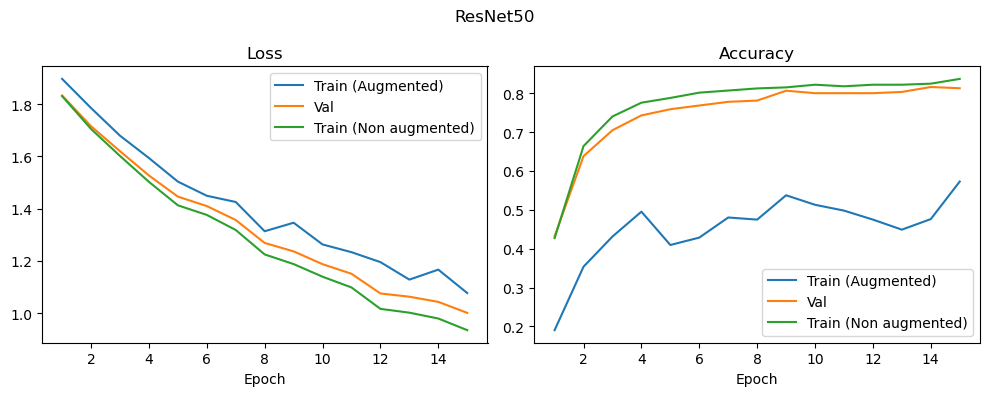

In [30]:
plot_history(history_resnet, title="ResNet50")

## Vision Transformer (ViT-B/16)

In [31]:
vit_base = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes
)
vit_base = vit_base.to(device)

criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = optim.AdamW(vit_base.parameters(), lr=2e-5, weight_decay=1e-4)

patience = 3  # Nombre d'époques à attendre avant d'arrêter si aucune amélioration
patience_counter = 0 # Compteur pour le nombre d'époques sans amélioration

EPOCHS_VIT = 15
best_val_acc_vit = 0.0
history_vit = {"train_loss": [], "train_clean_loss": [], "val_loss": [], "train_acc": [], "train_clean_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS_VIT + 1):
    train_loss, train_acc = train_one_epoch(vit_base, train_loader, criterion_vit, optimizer_vit)
    val_loss, val_acc, _, _ = evaluate(vit_base, test_loader, criterion_vit)
    # accuracy sur train sans augmentation
    train_clean_loss, train_clean_acc, _, _ = evaluate(vit_base, train_loader_clean, criterion_vit)

    history_vit["train_loss"].append(train_loss)
    history_vit["train_clean_loss"].append(train_clean_loss)
    history_vit["val_loss"].append(val_loss)
    history_vit["train_acc"].append(train_acc)
    history_vit["train_clean_acc"].append(train_clean_acc)
    history_vit["val_acc"].append(val_acc)

    print(f"[ViT] Epoch {epoch:02d} | "
          f"Train loss={train_loss:.3f}, acc={train_acc:.3f} | "
          f"Val loss={val_loss:.3f}, acc={val_acc:.3f} | "
          f"Train(clean) loss={train_clean_loss:.3f}, acc={train_clean_acc:.3f}")

    if val_acc > best_val_acc_vit:
        best_val_acc_vit = val_acc
        torch.save(vit_base.state_dict(), "vit_base_patch16_224_best.pth")
        patience_counter = 0  # Réinitialiser le compteur de patience car une amélioration a été trouvée
    else:
        patience_counter += 1 # Incrémenter le compteur de patience

    if patience_counter >= patience: # Si le compteur dépasse la patience, arrêter l'entraînement
        print(f"Early stopping après {epoch} epochs. La précision de la validation ne s'est pas améliorée pour {patience} epochs consécutifs.")
        break

batch 0/46 | loss=2.601 | acc=0.062


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.383 | acc=0.271
batch 40/46 | loss=0.859 | acc=0.393


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 01 | Train loss=1.368, acc=0.401 | Val loss=0.607, acc=0.835 | Train(clean) loss=0.477, acc=0.891
batch 0/46 | loss=0.678 | acc=0.188
batch 20/46 | loss=0.189 | acc=0.646


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.618 | acc=0.518


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 02 | Train loss=0.773, acc=0.520 | Val loss=0.491, acc=0.870 | Train(clean) loss=0.281, acc=0.939
batch 0/46 | loss=1.033 | acc=0.312
batch 20/46 | loss=0.795 | acc=0.497
batch 40/46 | loss=0.405 | acc=0.506


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 03 | Train loss=0.678, acc=0.525 | Val loss=0.444, acc=0.879 | Train(clean) loss=0.162, acc=0.971
batch 0/46 | loss=0.468 | acc=0.250


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=0.446 | acc=0.679
batch 40/46 | loss=0.163 | acc=0.668


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 04 | Train loss=0.525, acc=0.653 | Val loss=0.423, acc=0.883 | Train(clean) loss=0.105, acc=0.985
batch 0/46 | loss=0.088 | acc=0.125
batch 20/46 | loss=0.307 | acc=0.613


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.087 | acc=0.643


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 05 | Train loss=0.501, acc=0.635 | Val loss=0.406, acc=0.879 | Train(clean) loss=0.071, acc=0.993
batch 0/46 | loss=0.021 | acc=0.188
batch 20/46 | loss=0.833 | acc=0.548


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.700 | acc=0.627


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 06 | Train loss=0.485, acc=0.599 | Val loss=0.408, acc=0.898 | Train(clean) loss=0.076, acc=0.993
batch 0/46 | loss=0.183 | acc=0.188
batch 20/46 | loss=0.671 | acc=0.685
batch 40/46 | loss=0.821 | acc=0.627


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 07 | Train loss=0.481, acc=0.615 | Val loss=0.413, acc=0.879 | Train(clean) loss=0.050, acc=0.999
batch 0/46 | loss=0.766 | acc=0.875
batch 20/46 | loss=0.720 | acc=0.655


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.025 | acc=0.593


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 08 | Train loss=0.399, acc=0.582 | Val loss=0.411, acc=0.883 | Train(clean) loss=0.046, acc=0.996
batch 0/46 | loss=0.154 | acc=0.250
batch 20/46 | loss=0.046 | acc=0.524


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (91625885 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.169 | acc=0.512


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 09 | Train loss=0.416, acc=0.536 | Val loss=0.392, acc=0.898 | Train(clean) loss=0.038, acc=0.997
Early stopping après 9 epochs. La précision de la validation ne s'est pas améliorée pour 3 epochs consécutifs.


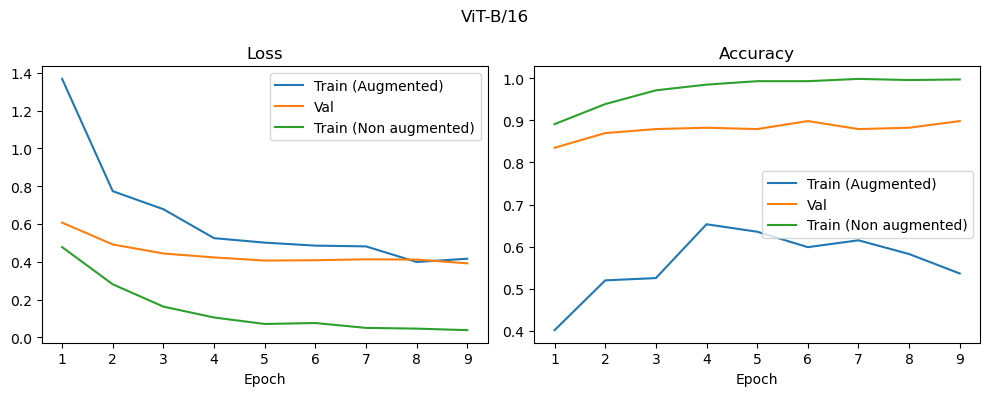

In [32]:
plot_history(history_vit, title="ViT-B/16")

## Évaluation finale sur le test set

ResNet50 - Test loss=1.044, acc=0.816
                            precision    recall  f1-score   support

                 Baby Care       0.78      0.69      0.73        45
  Beauty and Personal Care       0.92      0.80      0.86        45
                 Computers       0.75      0.89      0.82        45
Home Decor & Festive Needs       0.73      0.78      0.75        45
           Home Furnishing       0.81      0.84      0.83        45
          Kitchen & Dining       0.85      0.78      0.81        45
                   Watches       0.89      0.93      0.91        45

                  accuracy                           0.82       315
                 macro avg       0.82      0.82      0.82       315
              weighted avg       0.82      0.82      0.82       315

ViT-B/16 - Test loss=0.408, acc=0.898
                            precision    recall  f1-score   support

                 Baby Care       0.81      0.84      0.83        45
  Beauty and Personal Care       0.9

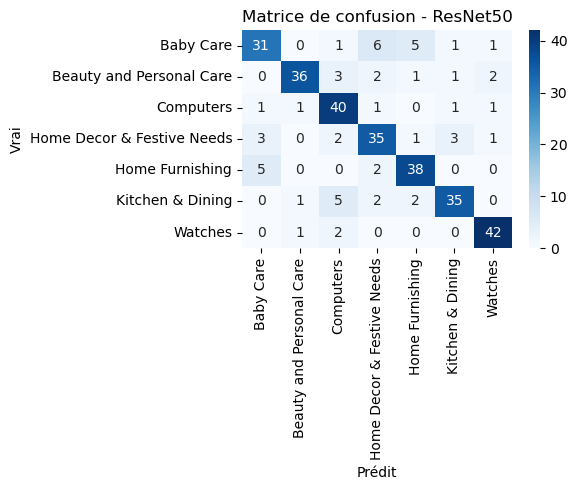

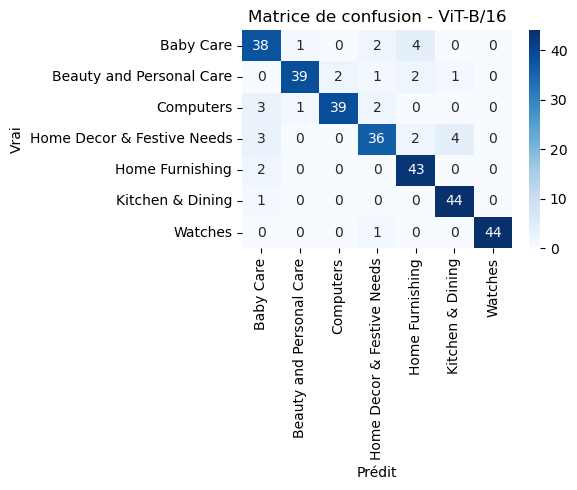

In [33]:
# Charger les meilleurs poids
resnet.load_state_dict(torch.load("resnet50_best.pth", map_location=device))
vit_base.load_state_dict(torch.load("vit_base_patch16_224_best.pth", map_location=device))

# ResNet
test_loss_r, test_acc_r, y_true_r, y_pred_r = evaluate(resnet, test_loader, criterion)
print(f"ResNet50 - Test loss={test_loss_r:.3f}, acc={test_acc_r:.3f}")
print(classification_report(y_true_r, y_pred_r, target_names=classes))

# ViT
test_loss_v, test_acc_v, y_true_v, y_pred_v = evaluate(vit_base, test_loader, criterion_vit)
print(f"ViT-B/16 - Test loss={test_loss_v:.3f}, acc={test_acc_v:.3f}")
print(classification_report(y_true_v, y_pred_v, target_names=classes))

# Matrices de confusion
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(y_true_r, y_pred_r, "Matrice de confusion - ResNet50")
plot_confusion(y_true_v, y_pred_v, "Matrice de confusion - ViT-B/16")

## Phase d'amelioration du ViT

### Phase 1

In [34]:
vit_phase1 = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes,
    drop_rate=0.1,        # dropout
    drop_path_rate=0.1    # stochastic depth
).to(device)

In [35]:
# on freeze tout
for p in vit_phase1.parameters():
    p.requires_grad = False

# on degele la head et le classifier
for name, p in vit_phase1.named_parameters():
    if "head" in name:
        p.requires_grad = True

criterion_vit = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer_vit = optim.AdamW(
    filter(lambda p: p.requires_grad, vit_phase1.parameters()),
    lr=1e-3,
    weight_decay=0.05
)

EPOCHS_PHASE1 = 5

### Boucle d'entrainment phase 1

In [36]:
best_val_loss = float("inf")

history_vit = {"train_loss": [], "train_clean_loss": [], "val_loss": [], "train_acc": [], "train_clean_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS_PHASE1 + 1):
    train_loss, train_acc = train_one_epoch(vit_phase1, train_loader, criterion_vit, optimizer_vit)
    val_loss, val_acc, _, _ = evaluate(vit_phase1, test_loader, criterion_vit)
    # accuracy sur train sans augmentation
    train_clean_loss, train_clean_acc, _, _ = evaluate(vit_phase1, train_loader_clean, criterion_vit)

    history_vit["train_loss"].append(train_loss)
    history_vit["train_clean_loss"].append(train_clean_loss)
    history_vit["val_loss"].append(val_loss)
    history_vit["train_acc"].append(train_acc)
    history_vit["train_clean_acc"].append(train_clean_acc)
    history_vit["val_acc"].append(val_acc)

    print(f"[ViT] Phase 1 - Epoch {epoch:02d} | Train loss={train_loss:.3f}, acc={train_acc:.3f} | Val loss={val_loss:.3f}, acc={val_acc:.3f} | Train(clean) loss={train_clean_loss:.3f}, acc={train_clean_acc:.3f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(vit_phase1.state_dict(), "vit_phase1_best.pth")

batch 0/46 | loss=2.108 | acc=0.375


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (91646808 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.302 | acc=0.354
batch 40/46 | loss=1.086 | acc=0.409


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 1 - Epoch 01 | Train loss=1.548, acc=0.410 | Val loss=0.935, acc=0.813 | Train(clean) loss=0.887, acc=0.823
batch 0/46 | loss=1.023 | acc=0.750


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.130 | acc=0.426
batch 40/46 | loss=0.842 | acc=0.500


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 1 - Epoch 02 | Train loss=1.216, acc=0.494 | Val loss=0.863, acc=0.829 | Train(clean) loss=0.786, acc=0.880
batch 0/46 | loss=2.095 | acc=0.625
batch 20/46 | loss=1.098 | acc=0.560
batch 40/46 | loss=1.424 | acc=0.523


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 1 - Epoch 03 | Train loss=1.157, acc=0.513 | Val loss=0.861, acc=0.832 | Train(clean) loss=0.747, acc=0.895
batch 0/46 | loss=0.823 | acc=0.938


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.059 | acc=0.491
batch 40/46 | loss=0.944 | acc=0.476


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 1 - Epoch 04 | Train loss=1.114, acc=0.473 | Val loss=0.850, acc=0.841 | Train(clean) loss=0.703, acc=0.913
batch 0/46 | loss=0.613 | acc=0.188
batch 20/46 | loss=1.327 | acc=0.500


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.886 | acc=0.508


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 1 - Epoch 05 | Train loss=1.061, acc=0.518 | Val loss=0.835, acc=0.863 | Train(clean) loss=0.683, acc=0.928


In [37]:
vit_phase1.load_state_dict(torch.load("vit_phase1_best.pth", map_location=device))

<All keys matched successfully>

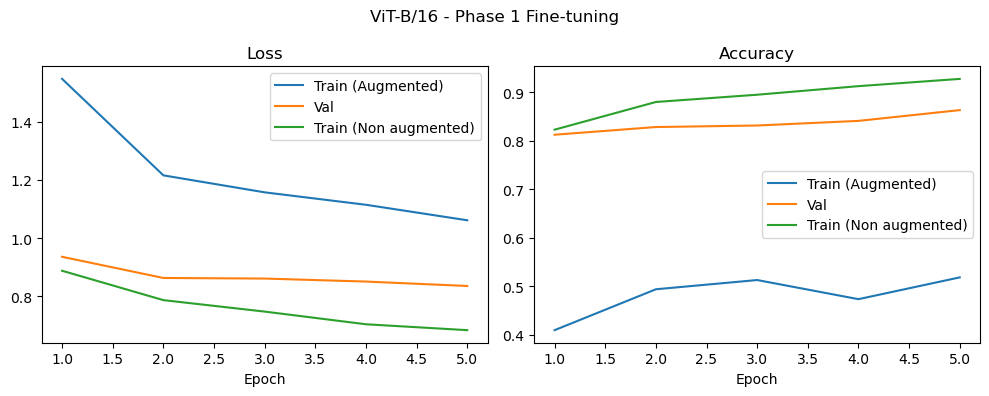

In [38]:
plot_history(history_vit, title="ViT-B/16 - Phase 1 Fine-tuning")

### Phase 2

In [39]:
vit_phase2 = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes,
    drop_rate=0.1,        # dropout
    drop_path_rate=0.1    # stochastic depth
).to(device)

In [40]:
# on degele head + derniers blocks
for name, p in vit_phase2.named_parameters():
    if ("blocks.10" in name) or ("blocks.11" in name) or ("head" in name) or ("norm" in name):
        p.requires_grad = True

# LR plus bas pour backbone, plus haut pour head
backbone_params = []
head_params = []

for name, p in vit_phase2.named_parameters():
    if not p.requires_grad:
        continue
    if "head" in name:
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer_vit = optim.AdamW(
    [
        {"params": backbone_params, "lr": 5e-5},
        {"params": head_params, "lr": 2e-4},
    ],
    weight_decay=0.05
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_vit, mode="min", factor=0.5, patience=2
)

EPOCHS_PHASE2 = 10

### Boucle d'entrainement phase 2

In [41]:
patience = 5
min_delta = 1e-3
best_val_loss = float("inf")
patience_counter = 0

history_vit = {"train_loss": [], "train_clean_loss": [], "val_loss": [], "train_acc": [], "train_clean_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS_PHASE2 + 1):
    train_loss, train_acc = train_one_epoch(vit_phase2, train_loader, criterion_vit, optimizer_vit)
    val_loss, val_acc, _, _ = evaluate(vit_phase2, test_loader, criterion_vit)
    # accuracy sur train sans augmentation
    train_clean_loss, train_clean_acc, _, _ = evaluate(vit_phase2, train_loader_clean, criterion_vit)

    history_vit["train_loss"].append(train_loss)
    history_vit["train_clean_loss"].append(train_clean_loss)
    history_vit["val_loss"].append(val_loss)
    history_vit["train_acc"].append(train_acc)
    history_vit["train_clean_acc"].append(train_clean_acc)
    history_vit["val_acc"].append(val_acc)

    print(f"[ViT] Phase 2 - Epoch {epoch:02d} | Train loss={train_loss:.3f}, acc={train_acc:.3f} | Val loss={val_loss:.3f}, acc={val_acc:.3f} | Train(clean) loss={train_clean_loss:.3f}, acc={train_clean_acc:.3f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        torch.save(vit_phase2.state_dict(), "vit_phase2_best.pth")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping après {epoch} epochs (val_loss n'améliore plus).")
        break

batch 0/46 | loss=2.575 | acc=0.125
batch 20/46 | loss=1.095 | acc=0.321
batch 40/46 | loss=1.488 | acc=0.404


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 01 | Train loss=1.481, acc=0.392 | Val loss=0.930, acc=0.803 | Train(clean) loss=0.816, acc=0.868
batch 0/46 | loss=0.656 | acc=0.312
batch 20/46 | loss=1.136 | acc=0.500


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.257 | acc=0.518


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 02 | Train loss=1.004, acc=0.517 | Val loss=0.840, acc=0.841 | Train(clean) loss=0.641, acc=0.939
batch 0/46 | loss=0.607 | acc=0.938
batch 20/46 | loss=0.621 | acc=0.714


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.951 | acc=0.645


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 03 | Train loss=0.975, acc=0.649 | Val loss=0.778, acc=0.867 | Train(clean) loss=0.566, acc=0.976
batch 0/46 | loss=1.244 | acc=0.188
batch 20/46 | loss=1.291 | acc=0.533


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.776 | acc=0.598


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 04 | Train loss=0.838, acc=0.595 | Val loss=0.767, acc=0.867 | Train(clean) loss=0.523, acc=0.981
batch 0/46 | loss=0.485 | acc=1.000
batch 20/46 | loss=1.157 | acc=0.690
batch 40/46 | loss=0.655 | acc=0.669


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 05 | Train loss=0.837, acc=0.639 | Val loss=0.763, acc=0.873 | Train(clean) loss=0.511, acc=0.992
batch 0/46 | loss=1.263 | acc=0.562


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=0.831 | acc=0.548
batch 40/46 | loss=0.496 | acc=0.654


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 06 | Train loss=0.780, acc=0.665 | Val loss=0.755, acc=0.873 | Train(clean) loss=0.485, acc=0.996
batch 0/46 | loss=0.696 | acc=0.312
batch 20/46 | loss=1.132 | acc=0.667


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.512 | acc=0.634


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 07 | Train loss=0.813, acc=0.620 | Val loss=0.788, acc=0.870 | Train(clean) loss=0.508, acc=0.995
batch 0/46 | loss=0.542 | acc=1.000


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=0.840 | acc=0.670
batch 40/46 | loss=1.041 | acc=0.631


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 08 | Train loss=0.773, acc=0.614 | Val loss=0.781, acc=0.854 | Train(clean) loss=0.481, acc=0.999
batch 0/46 | loss=0.470 | acc=1.000
batch 20/46 | loss=1.017 | acc=0.512
batch 40/46 | loss=0.555 | acc=0.591


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 09 | Train loss=0.782, acc=0.610 | Val loss=0.774, acc=0.867 | Train(clean) loss=0.477, acc=0.999
batch 0/46 | loss=0.961 | acc=0.188
batch 20/46 | loss=0.574 | acc=0.589


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (89499696 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.530 | acc=0.639


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 10 | Train loss=0.756, acc=0.588 | Val loss=0.762, acc=0.863 | Train(clean) loss=0.472, acc=1.000


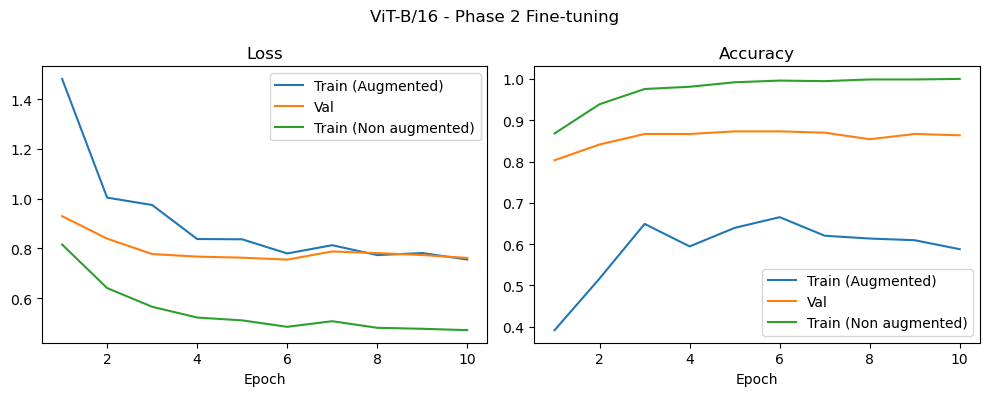

In [42]:
plot_history(history_vit, title="ViT-B/16 - Phase 2 Fine-tuning")

### je charge le meilleur modele

#### Phase 1

In [43]:
vit_phase1.load_state_dict(torch.load("vit_phase1_best.pth", map_location=device))
vit_phase1.eval()

test_loss_v1, test_acc_v1, y_true_v1, y_pred_v1 = evaluate(vit_phase1, test_loader, criterion_vit)

print(f"[ViT] Best - Test loss={test_loss_v1:.3f} | acc={test_acc_v1:.3f}")

[ViT] Best - Test loss=0.835 | acc=0.863


                            precision    recall  f1-score   support

                 Baby Care       0.82      0.69      0.75        45
  Beauty and Personal Care       0.95      0.87      0.91        45
                 Computers       0.92      0.78      0.84        45
Home Decor & Festive Needs       0.76      0.87      0.81        45
           Home Furnishing       0.83      0.89      0.86        45
          Kitchen & Dining       0.84      0.96      0.90        45
                   Watches       0.94      1.00      0.97        45

                  accuracy                           0.86       315
                 macro avg       0.87      0.86      0.86       315
              weighted avg       0.87      0.86      0.86       315



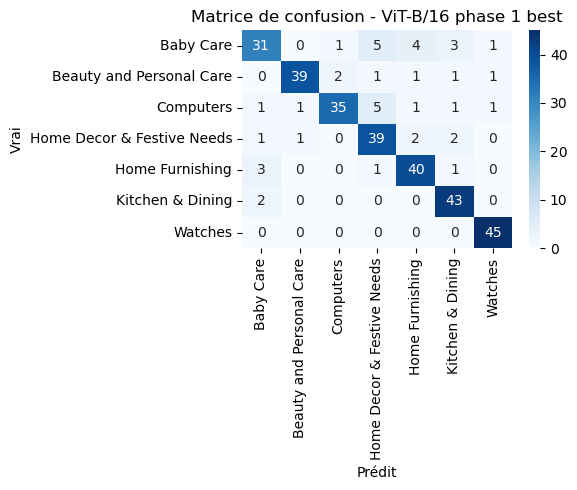

In [44]:
print(classification_report(y_true_v1, y_pred_v1, target_names=classes))

# Matrices de confusion
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(y_true_v1, y_pred_v1, "Matrice de confusion - ViT-B/16 phase 1 best")

#### Phase 2

In [45]:
vit_phase2.load_state_dict(torch.load("vit_phase2_best.pth", map_location=device))
vit_phase2.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [46]:
test_loss_v2, test_acc_v2, y_true_v2, y_pred_v2 = evaluate(vit_phase2, test_loader, criterion_vit)

print(f"[ViT] Best - Test loss={test_loss_v2:.3f} | acc={test_acc_v2:.3f}")

[ViT] Best - Test loss=0.755 | acc=0.873


                            precision    recall  f1-score   support

                 Baby Care       0.86      0.80      0.83        45
  Beauty and Personal Care       0.95      0.78      0.85        45
                 Computers       0.91      0.87      0.89        45
Home Decor & Festive Needs       0.81      0.84      0.83        45
           Home Furnishing       0.81      0.93      0.87        45
          Kitchen & Dining       0.86      0.96      0.91        45
                   Watches       0.95      0.93      0.94        45

                  accuracy                           0.87       315
                 macro avg       0.88      0.87      0.87       315
              weighted avg       0.88      0.87      0.87       315



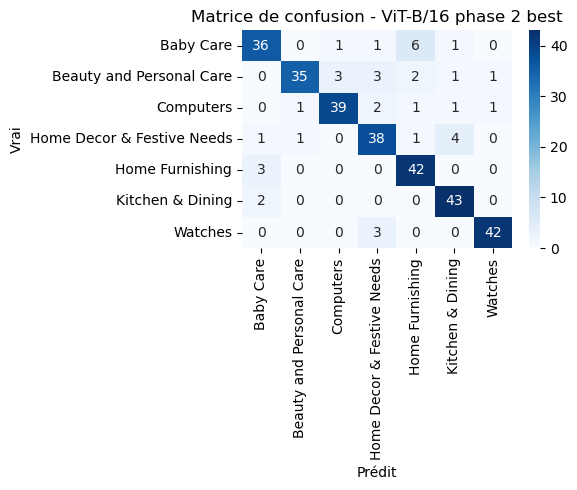

In [47]:
print(classification_report(y_true_v2, y_pred_v2, target_names=classes))

# Matrices de confusion
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(y_true_v2, y_pred_v2, "Matrice de confusion - ViT-B/16 phase 2 best")

### Comparatif des modeles ResNet50 / ViT base / ViT phase 1 / ViT phase 2

ResNet50 - Test loss=1.044, acc=0.816
                            precision    recall  f1-score   support

                 Baby Care       0.78      0.69      0.73        45
  Beauty and Personal Care       0.92      0.80      0.86        45
                 Computers       0.75      0.89      0.82        45
Home Decor & Festive Needs       0.73      0.78      0.75        45
           Home Furnishing       0.81      0.84      0.83        45
          Kitchen & Dining       0.85      0.78      0.81        45
                   Watches       0.89      0.93      0.91        45

                  accuracy                           0.82       315
                 macro avg       0.82      0.82      0.82       315
              weighted avg       0.82      0.82      0.82       315

ViT-B/16 - Test loss=0.813, acc=0.898
                            precision    recall  f1-score   support

                 Baby Care       0.81      0.84      0.83        45
  Beauty and Personal Care       0.9

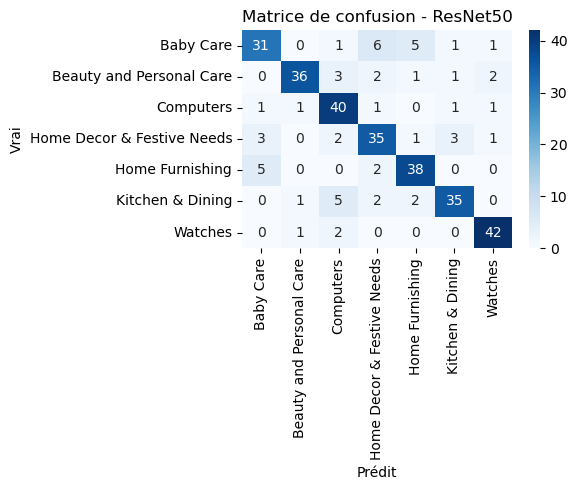

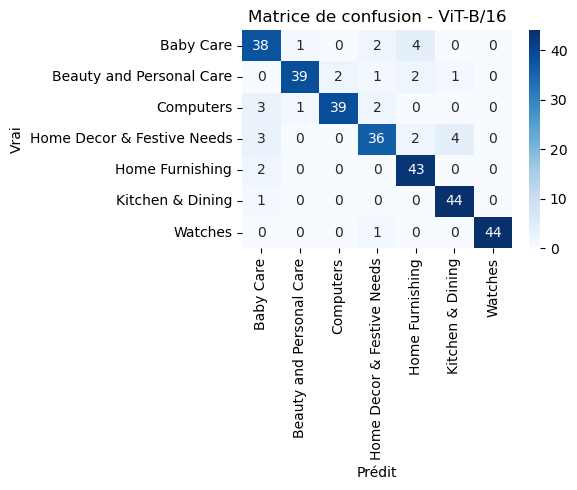

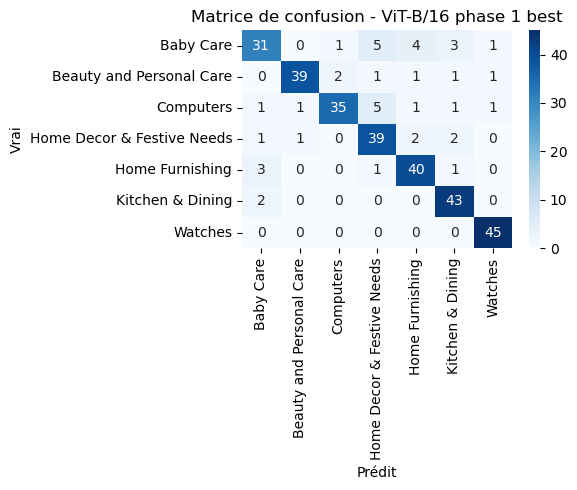

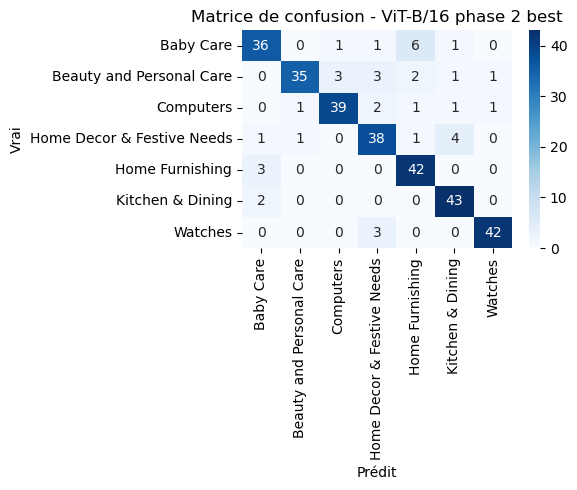

In [48]:
# Charger les meilleurs poids
resnet.load_state_dict(torch.load("resnet50_best.pth", map_location=device))
vit_base.load_state_dict(torch.load("vit_base_patch16_224_best.pth", map_location=device))
vit_phase1.load_state_dict(torch.load("vit_phase1_best.pth", map_location=device))
vit_phase2.load_state_dict(torch.load("vit_phase2_best.pth", map_location=device))

# ResNet
test_loss_r, test_acc_r, y_true_r, y_pred_r = evaluate(resnet, test_loader, criterion)
print(f"ResNet50 - Test loss={test_loss_r:.3f}, acc={test_acc_r:.3f}")
print(classification_report(y_true_r, y_pred_r, target_names=classes))

# ViT
test_loss_v, test_acc_v, y_true_v, y_pred_v = evaluate(vit_base, test_loader, criterion_vit)
print(f"ViT-B/16 - Test loss={test_loss_v:.3f}, acc={test_acc_v:.3f}")
print(classification_report(y_true_v, y_pred_v, target_names=classes))

# ViT Phase 1 best
test_loss_v1, test_acc_v1, y_true_v1, y_pred_v1 = evaluate(vit_phase1, test_loader, criterion_vit)
print(f"ViT-B/16 Phase 1 - Test loss={test_loss_v1:.3f}, acc={test_acc_v1:.3f}")
print(classification_report(y_true_v1, y_pred_v1, target_names=classes))

# ViT Phase 2 best
test_loss_v2, test_acc_v2, y_true_v2, y_pred_v2 = evaluate(vit_phase2, test_loader, criterion_vit)
print(f"ViT-B/16 Phase 2 - Test loss={test_loss_v2:.3f}, acc={test_acc_v2:.3f}")
print(classification_report(y_true_v2, y_pred_v2, target_names=classes))

# Matrices de confusion
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(y_true_r, y_pred_r, "Matrice de confusion - ResNet50")
plot_confusion(y_true_v, y_pred_v, "Matrice de confusion - ViT-B/16")
plot_confusion(y_true_v1, y_pred_v1, "Matrice de confusion - ViT-B/16 phase 1 best")
plot_confusion(y_true_v2, y_pred_v2, "Matrice de confusion - ViT-B/16 phase 2 best")

#### Phase 3

In [49]:
vit_phase3 = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes,
    drop_rate=0.1,
    drop_path_rate=0.1
).to(device)

In [50]:
# je freeze tout
for p in vit_phase3.parameters():
    p.requires_grad = False

In [51]:
# je charge le meilleur modele de phase 1
vit_phase3.load_state_dict(torch.load("vit_phase1_best.pth", map_location=device))

<All keys matched successfully>

In [52]:
# la je unfreeze head + derniers blocks + norm
for name, p in vit_phase3.named_parameters():
    if ("blocks.10" in name) or ("blocks.11" in name) or ("head" in name) or ("norm" in name):
        p.requires_grad = True

In [53]:
# params groups + LR plus doux
backbone_params, head_params = [], []
for name, p in vit_phase3.named_parameters():
    if not p.requires_grad:
        continue
    if "head" in name:
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer_vit = optim.AdamW(
    [
        {"params": backbone_params, "lr": 1e-5},
        {"params": head_params, "lr": 5e-5},
    ],
    weight_decay=0.01
)

# scheduler ok
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_vit, mode="max", factor=0.5, patience=2
)

In [54]:
best_score = 0.0
patience = 5
patience_counter = 0

EPOCHS_PHASE3 = 10

for epoch in range(1, EPOCHS_PHASE3 + 1):
    train_loss, train_acc = train_one_epoch(vit_phase3, train_loader, criterion_vit, optimizer_vit)
    test_loss, test_acc, _, _ = evaluate(vit_phase3, test_loader, criterion_vit)

    print(f"[ViT] Phase 3 Epoch {epoch:02d} | Train acc={train_acc:.3f} | Test acc={test_acc:.3f}")

    scheduler.step(test_acc)

    # sauver sur accuracy
    if test_acc > best_score + 1e-3:
        best_score = test_acc
        torch.save(vit_phase3.state_dict(), "vit_phase3_best.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break

batch 0/46 | loss=1.515 | acc=0.188
batch 20/46 | loss=0.833 | acc=0.592


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.563 | acc=0.620
[ViT] Phase 3 Epoch 01 | Train acc=0.595 | Test acc=0.863
batch 0/46 | loss=0.672 | acc=0.250


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=0.865 | acc=0.405
batch 40/46 | loss=0.690 | acc=0.494
[ViT] Phase 3 Epoch 02 | Train acc=0.512 | Test acc=0.870
batch 0/46 | loss=1.093 | acc=0.188
batch 20/46 | loss=1.541 | acc=0.580
batch 40/46 | loss=1.031 | acc=0.566


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 3 Epoch 03 | Train acc=0.563 | Test acc=0.876


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 0/46 | loss=0.674 | acc=0.250
batch 20/46 | loss=1.375 | acc=0.679
batch 40/46 | loss=1.311 | acc=0.639
[ViT] Phase 3 Epoch 04 | Train acc=0.637 | Test acc=0.870
batch 0/46 | loss=1.484 | acc=0.625
batch 20/46 | loss=1.295 | acc=0.494


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.649 | acc=0.474
[ViT] Phase 3 Epoch 05 | Train acc=0.493 | Test acc=0.879
batch 0/46 | loss=0.636 | acc=1.000


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.276 | acc=0.625
batch 40/46 | loss=0.626 | acc=0.602
[ViT] Phase 3 Epoch 06 | Train acc=0.614 | Test acc=0.870
batch 0/46 | loss=0.664 | acc=0.875


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.325 | acc=0.625
batch 40/46 | loss=0.921 | acc=0.595
[ViT] Phase 3 Epoch 07 | Train acc=0.576 | Test acc=0.883
batch 0/46 | loss=1.511 | acc=0.688


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.518 | acc=0.461
batch 40/46 | loss=0.715 | acc=0.526
[ViT] Phase 3 Epoch 08 | Train acc=0.525 | Test acc=0.879
batch 0/46 | loss=1.095 | acc=0.250


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.476 | acc=0.619
batch 40/46 | loss=0.847 | acc=0.511
[ViT] Phase 3 Epoch 09 | Train acc=0.507 | Test acc=0.879
batch 0/46 | loss=0.633 | acc=0.188
batch 20/46 | loss=0.724 | acc=0.557


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.144 | acc=0.518
[ViT] Phase 3 Epoch 10 | Train acc=0.513 | Test acc=0.879


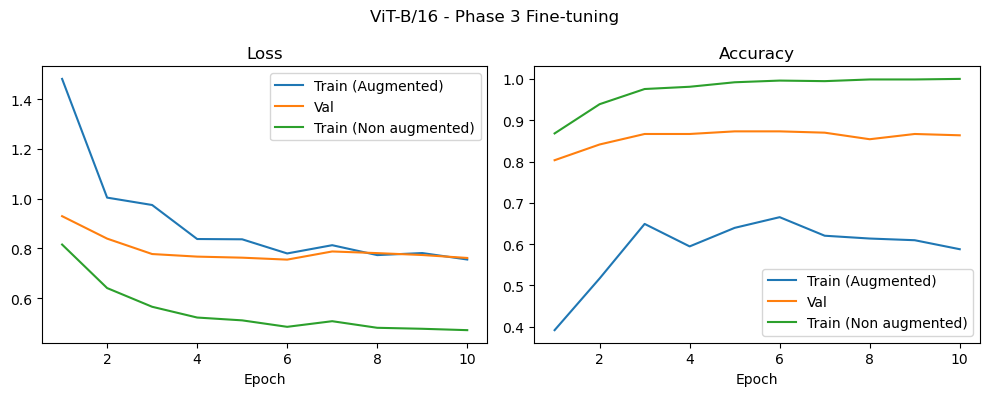

In [55]:
plot_history(history_vit, title="ViT-B/16 - Phase 3 Fine-tuning")

In [56]:
test_loss_v3, test_acc_v3, y_true_v3, y_pred_v3 = evaluate(vit_phase3, test_loader, criterion_vit)

print(f"[ViT] Best - Test loss={test_loss_v3:.3f} | acc={test_acc_v3:.3f}")

[ViT] Best - Test loss=0.791 | acc=0.879


                            precision    recall  f1-score   support

                 Baby Care       0.86      0.71      0.78        45
  Beauty and Personal Care       0.97      0.82      0.89        45
                 Computers       0.90      0.82      0.86        45
Home Decor & Festive Needs       0.77      0.89      0.82        45
           Home Furnishing       0.81      0.96      0.88        45
          Kitchen & Dining       0.90      0.98      0.94        45
                   Watches       0.98      0.98      0.98        45

                  accuracy                           0.88       315
                 macro avg       0.89      0.88      0.88       315
              weighted avg       0.89      0.88      0.88       315



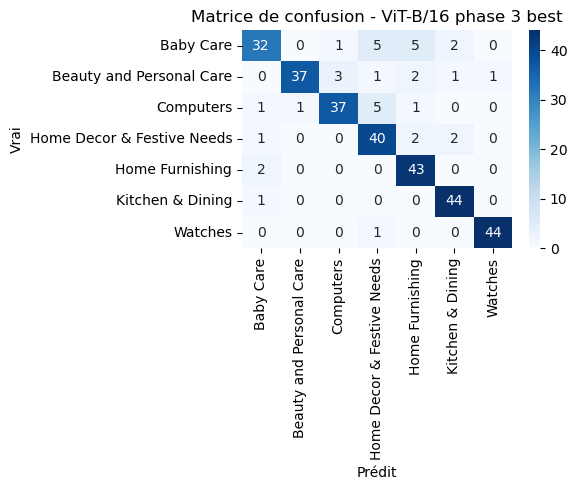

In [57]:
print(classification_report(y_true_v3, y_pred_v3, target_names=classes))

# Matrices de confusion
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(y_true_v3, y_pred_v3, "Matrice de confusion - ViT-B/16 phase 3 best")

## Comparaison final entre tous les modeles

ResNet50 - Test loss=1.044, acc=0.816
                            precision    recall  f1-score   support

                 Baby Care       0.78      0.69      0.73        45
  Beauty and Personal Care       0.92      0.80      0.86        45
                 Computers       0.75      0.89      0.82        45
Home Decor & Festive Needs       0.73      0.78      0.75        45
           Home Furnishing       0.81      0.84      0.83        45
          Kitchen & Dining       0.85      0.78      0.81        45
                   Watches       0.89      0.93      0.91        45

                  accuracy                           0.82       315
                 macro avg       0.82      0.82      0.82       315
              weighted avg       0.82      0.82      0.82       315

ViT-B/16 - Test loss=0.813, acc=0.898
                            precision    recall  f1-score   support

                 Baby Care       0.81      0.84      0.83        45
  Beauty and Personal Care       0.9

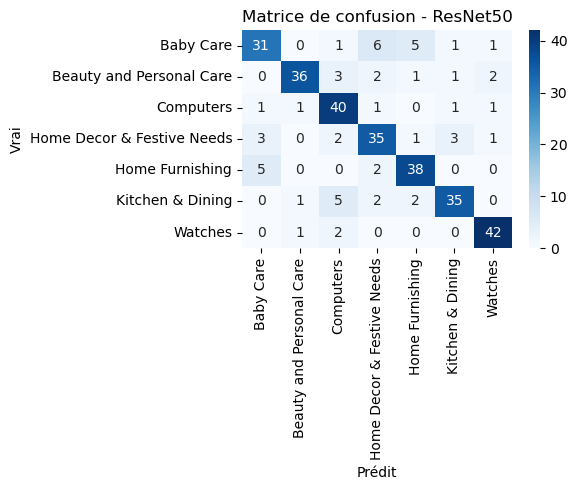

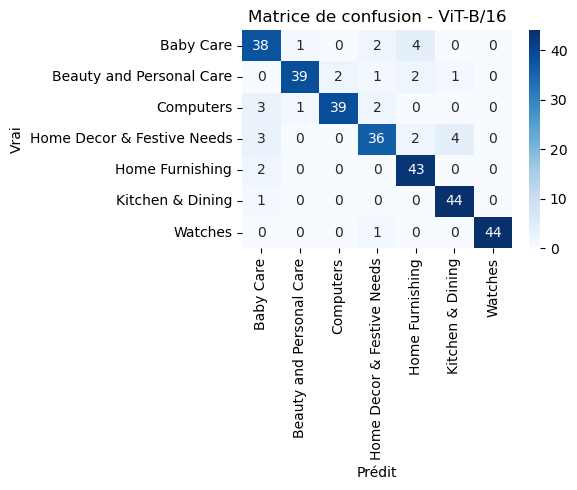

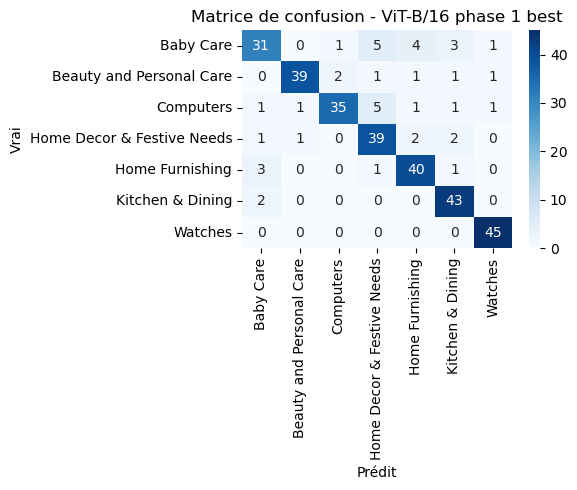

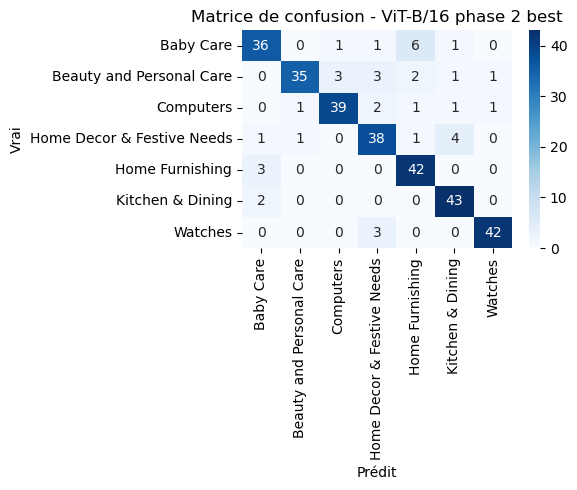

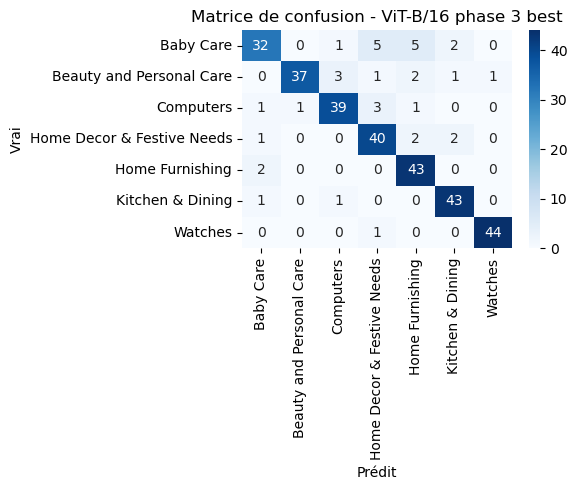

In [58]:
# Charger les meilleurs poids
resnet.load_state_dict(torch.load("resnet50_best.pth", map_location=device))
vit_base.load_state_dict(torch.load("vit_base_patch16_224_best.pth", map_location=device))
vit_phase1.load_state_dict(torch.load("vit_phase1_best.pth", map_location=device))
vit_phase2.load_state_dict(torch.load("vit_phase2_best.pth", map_location=device))
vit_phase3.load_state_dict(torch.load("vit_phase3_best.pth", map_location=device))

# ResNet
test_loss_r, test_acc_r, y_true_r, y_pred_r = evaluate(resnet, test_loader, criterion)
print(f"ResNet50 - Test loss={test_loss_r:.3f}, acc={test_acc_r:.3f}")
print(classification_report(y_true_r, y_pred_r, target_names=classes))

# ViT
test_loss_v, test_acc_v, y_true_v, y_pred_v = evaluate(vit_base, test_loader, criterion_vit)
print(f"ViT-B/16 - Test loss={test_loss_v:.3f}, acc={test_acc_v:.3f}")
print(classification_report(y_true_v, y_pred_v, target_names=classes))

# ViT Phase 1 best
test_loss_v1, test_acc_v1, y_true_v1, y_pred_v1 = evaluate(vit_phase1, test_loader, criterion_vit)
print(f"ViT-B/16 Phase 1 - Test loss={test_loss_v1:.3f}, acc={test_acc_v1:.3f}")
print(classification_report(y_true_v1, y_pred_v1, target_names=classes))

# ViT Phase 2 best
test_loss_v2, test_acc_v2, y_true_v2, y_pred_v2 = evaluate(vit_phase2, test_loader, criterion_vit)
print(f"ViT-B/16 Phase 2 - Test loss={test_loss_v2:.3f}, acc={test_acc_v2:.3f}")
print(classification_report(y_true_v2, y_pred_v2, target_names=classes))

# ViT Phase 3 best
test_loss_v3, test_acc_v3, y_true_v3, y_pred_v3 = evaluate(vit_phase3, test_loader, criterion_vit)
print(f"ViT-B/16 Phase 3 - Test loss={test_loss_v3:.3f}, acc={test_acc_v3:.3f}")
print(classification_report(y_true_v3, y_pred_v3, target_names=classes))

# Matrices de confusion
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(y_true_r, y_pred_r, "Matrice de confusion - ResNet50")
plot_confusion(y_true_v, y_pred_v, "Matrice de confusion - ViT-B/16")
plot_confusion(y_true_v1, y_pred_v1, "Matrice de confusion - ViT-B/16 phase 1 best")
plot_confusion(y_true_v2, y_pred_v2, "Matrice de confusion - ViT-B/16 phase 2 best")
plot_confusion(y_true_v3, y_pred_v3, "Matrice de confusion - ViT-B/16 phase 3 best")

# Explicabilite des modeles

### Grad-CAM pour ResNet50

#### On cherche a comprendre la ou le modele "regarde". Quelles sont les zones de l'image les plus responsables de la classe predite

In [64]:
def denormalize(img_tensor, mean, std):
    """img_tensor: [3,H,W] normalized -> back to [0,1]"""
    mean = torch.tensor(mean).view(3,1,1)
    std = torch.tensor(std).view(3,1,1)
    x = img_tensor.cpu() * std + mean
    return torch.clamp(x, 0, 1)

def overlay_heatmap_on_image(img_rgb, heatmap, alpha=0.45):
    """
    img_rgb: np.array [H,W,3] float [0,1]
    heatmap: np.array [H,W] float [0,1]
    """
    H, W, _ = img_rgb.shape
    
    # Resize heatmap to image size if needed
    if heatmap.shape != (H, W):
        heatmap = cv2.resize(heatmap, (W, H), interpolation=cv2.INTER_CUBIC)
        heatmap = np.clip(heatmap, 0, 1)
    
    cmap = plt.get_cmap("jet")
    heatmap_color = cmap(heatmap)[..., :3]
    
    out = (1 - alpha) * img_rgb + alpha * heatmap_color
    return np.clip(out, 0, 1)

In [65]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        self.fwd_hook = target_layer.register_forward_hook(self._save_activations)
        self.bwd_hook = target_layer.register_full_backward_hook(self._save_gradients)

    def _save_activations(self, module, inp, out):
        self.activations = out  # [B,C,H,W]

    def _save_gradients(self, module, grad_inp, grad_out):
        self.gradients = grad_out[0]  # [B,C,H,W]

    def __call__(self, x, class_idx=None):
        self.model.eval()
        x = x.requires_grad_(True)

        logits = self.model(x)  # [B,num_classes]
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()

        score = logits[:, class_idx].sum()
        self.model.zero_grad()
        score.backward(retain_graph=True)

        # weights: global average pooling over gradients
        grads = self.gradients[0]         # [C,H,W]
        acts  = self.activations[0]       # [C,H,W]
        weights = grads.mean(dim=(1,2))   # [C]

        cam = (weights[:, None, None] * acts).sum(dim=0)  # [H,W]
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam.detach().cpu().numpy(), class_idx

    def close(self):
        self.fwd_hook.remove()
        self.bwd_hook.remove()

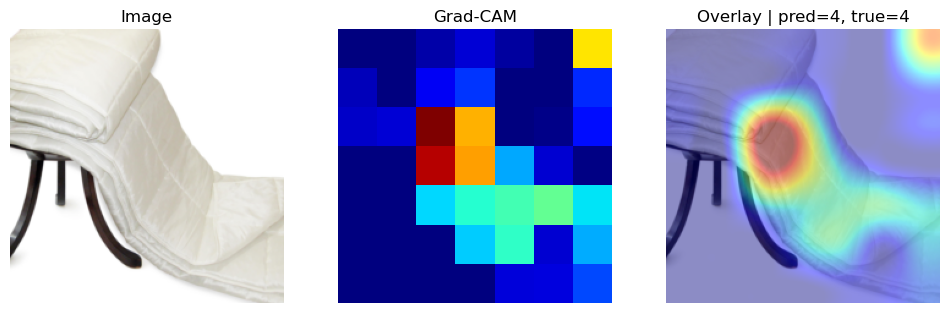

In [66]:
# mean/std ImageNet (comme tes transforms)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Choisir une image (ici depuis un batch du test_loader)
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# prends la 1ère image du batch
img_tensor = images[0]              # [3,224,224]
true_label = labels[0].item()

# Grad-CAM: cible = dernière couche conv (ResNet50)
# sur torchvision.resnet50 -> target_layer = resnet.layer4[-1]
target_layer = resnet.layer4[-1]  # adapte si ton modèle s'appelle autrement
cam = GradCAM(resnet, target_layer)

heatmap, pred_idx = cam(img_tensor.unsqueeze(0))
cam.close()

# Overlay sur image d'origine (dé-normalisée)
img_rgb = denormalize(img_tensor, IMAGENET_MEAN, IMAGENET_STD).permute(1,2,0).numpy()
overlay = overlay_heatmap_on_image(img_rgb, heatmap, alpha=0.45)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img_rgb); plt.axis("off")
plt.subplot(1,3,2); plt.title("Grad-CAM"); plt.imshow(heatmap, cmap="jet"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Overlay | pred={pred_idx}, true={true_label}")
plt.imshow(overlay); plt.axis("off")
plt.show()

#### Ici on voit bien les zones qui sont ciblees

### Attention Rollout pour ViT-B/16 (timm)

#### Maintenant avec ViT on veut voir quels patches influencent la decision du token CLS
#### Le “Rollout” = on agrège l’attention sur plusieurs couches

In [76]:
import torch.nn.functional as F

In [77]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def denormalize(img_tensor, mean, std):
    """img_tensor: [3,H,W] normalized -> back to [0,1]"""
    mean = torch.tensor(mean).view(3,1,1)
    std = torch.tensor(std).view(3,1,1)
    x = img_tensor.detach().cpu() * std + mean
    return torch.clamp(x, 0, 1)

def overlay_heatmap_on_image(img_rgb, heatmap, alpha=0.45):
    """
    img_rgb: np.array [H,W,3] float [0,1]
    heatmap: np.array [h,w] float [0,1] -> upsampled to [H,W] if needed
    """
    H, W, _ = img_rgb.shape
    if heatmap.shape != (H, W):
        heatmap = cv2.resize(heatmap, (W, H), interpolation=cv2.INTER_CUBIC)
        heatmap = np.clip(heatmap, 0, 1)

    cmap = plt.get_cmap("jet")
    heatmap_color = cmap(heatmap)[..., :3]
    out = (1 - alpha) * img_rgb + alpha * heatmap_color
    return np.clip(out, 0, 1)

def get_vit_attention_rollout_map(vit_model, img_tensor, device="cpu"):
    """
    vit_model : timm ViT (vit_base_patch16_224)
    img_tensor : torch.Tensor [3,224,224] NORMALISÉ ImageNet
    return : np.array [224,224] in [0,1]
    """
    vit_model.eval()

    attn_mats = []
    handles = []

    # Hook: input de attn_drop = matrices d'attention [B, heads, T, T]
    def hook_fn(module, inp, out):
        attn_mats.append(inp[0].detach())

    for blk in vit_model.blocks:
        handles.append(blk.attn.attn_drop.register_forward_hook(hook_fn))

    with torch.no_grad():
        _ = vit_model(img_tensor.unsqueeze(0).to(device))

    for h in handles:
        h.remove()

    if len(attn_mats) == 0:
        raise RuntimeError("Aucune attention capturée. Vérifie que ton modèle est bien un timm ViT (vit_model.blocks).")

    # Rollout (agrégation des attentions sur les couches)
    B, H, T, _ = attn_mats[0].shape
    dev = attn_mats[0].device
    joint_attn = torch.eye(T, device=dev).unsqueeze(0).repeat(B, 1, 1)  # [B,T,T]

    for attn in attn_mats:
        attn_fused = attn.mean(dim=1)  # [B,T,T] (avg heads)
        attn_fused = attn_fused + torch.eye(T, device=dev).unsqueeze(0)  # skip connection
        attn_fused = attn_fused / attn_fused.sum(dim=-1, keepdim=True)   # normalize
        joint_attn = attn_fused @ joint_attn

    # CLS -> patches
    cls_to_patches = joint_attn[:, 0, 1:]  # [B, num_patches]
    num_patches = cls_to_patches.shape[-1]
    grid = int(np.sqrt(num_patches))  # 224/16 => 14
    assert grid * grid == num_patches, f"num_patches={num_patches} n'est pas un carré parfait"

    mask = cls_to_patches.reshape(B, grid, grid).unsqueeze(1)  # [B,1,14,14]
    mask = F.interpolate(mask, size=(img_tensor.shape[1], img_tensor.shape[2]), mode="bilinear", align_corners=False)
    mask = mask.squeeze(1)  # [B,224,224]

    # Normalize 0..1
    mask = mask - mask.amin(dim=(1,2), keepdim=True)
    mask = mask / (mask.amax(dim=(1,2), keepdim=True) + 1e-8)

    return mask[0].detach().cpu().numpy()

def show_vit_rollout(vit_model, img_tensor, true_label=None, device="cpu", alpha=0.45):
    heatmap = get_vit_attention_rollout_map(vit_model.to(device), img_tensor, device=device)

    img_rgb = denormalize(img_tensor, IMAGENET_MEAN, IMAGENET_STD).permute(1,2,0).numpy()
    overlay = overlay_heatmap_on_image(img_rgb, heatmap, alpha=alpha)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img_rgb); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Rollout"); plt.imshow(heatmap, cmap="jet"); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
    if true_label is not None:
        plt.suptitle(f"ViT Attention Rollout | true={true_label}")
    plt.tight_layout()
    plt.show()

In [96]:
vit_model_to_explain = vit_phase3

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

img_tensor = images[3].detach().cpu()       # [3,224,224] (reste normalisée)
true_label = labels[3].item()

In [97]:
for blk in vit_model_to_explain.blocks:
    if hasattr(blk.attn, "fused_attn"):
        blk.attn.fused_attn = False

In [98]:
print(type(vit_model_to_explain))
print("blocks:", hasattr(vit_model_to_explain, "blocks"))
print("attn has fused_attn:", hasattr(vit_model_to_explain.blocks[0].attn, "fused_attn"))
print("attn has use_fused_attn:", hasattr(vit_model_to_explain.blocks[0].attn, "use_fused_attn"))

<class 'timm.models.vision_transformer.VisionTransformer'>
blocks: True
attn has fused_attn: True
attn has use_fused_attn: False


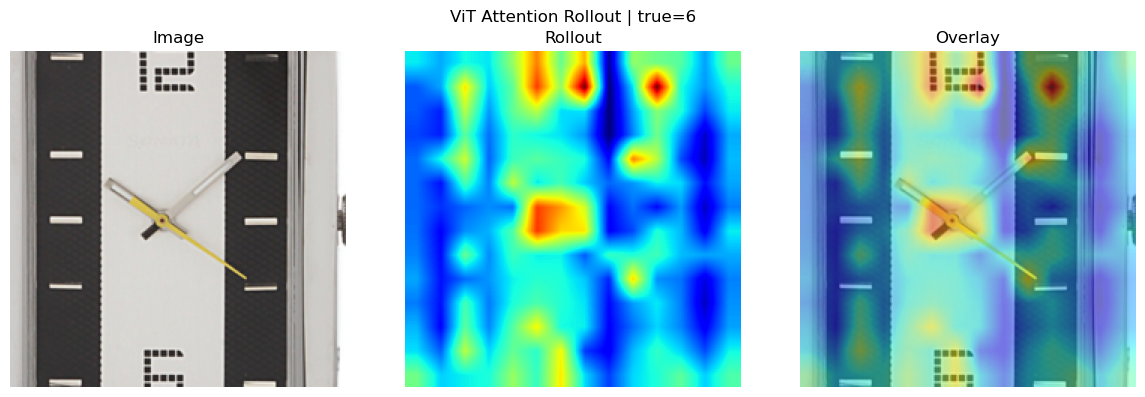

In [99]:
show_vit_rollout(vit_model_to_explain, img_tensor, true_label=true_label, device=device, alpha=0.45)